This notebook is not intended to be a tutorial; in the following I will show a way to represent texts in a graph form and develop a machine learning approach to classify them. The main idea is to represent each text as a graph, where nodes are unique words in the text and edges are formed between adiacent words. The graph is then augmented by adding features to each node using the the Node2Vec algorithm. 
I will then use a Graph Convolutional Network to combine the vector representation of each node with the topology of the graph to classify each node in the graph. The network will be trained on a set of labeled texts and will be able to classify new words/texts.

The main advantage of this approach is that it does not require any preprocessing of the text, such as tokenization, stemming, etc. The only preprocessing step is to remove the punctuation and to convert all words to lowercase. 

Currently, the graph representation has no notion of semantic similarity between words as the only information fed to the network is the topology of the graph and the vectorial representation of each node learned by node2vec. Thas said, the graph representation is also very simple and can be easily extended to include more information about the words. 
Also, because of the way the graph is constructed, the same code can be used to compare texts of different lengths, even if the aren't in the same language and can in fact be used to compare the structure (graph topology) of texts in different languages.

We stard by importing the necessary libraries:

In [2]:
#%%
import random
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset

from tqdm import tqdm
import copy
from torch import nn
from sklearn.decomposition import PCA
from node2vec import Node2Vec as n2v
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

from torch_geometric.data import Data as GraphData
from sklearn.manifold import TSNE
import numpy as np
import umap
import pandas as pd

MAX_RANGE = 10
LINK_TRESHOLD = 5.5
LINK_MAX_WEIGHT = 1000

# N_TEXTS = 9000

We then declare some helper funcions to create and plot the graphs using the library networkx:

In [3]:
def build_graph(doc):
    # preprocess document for standardization
    pdoc = preprocess_document(doc)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    #drop nodes with NoneType
    nodes = [node for node in nodes if node != None]
    
    # get graph edges
    edges = get_relations(pdoc)
    
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

def preprocess_document(document, sentence_spliter='.', word_spliter=' ', punct_mark=','):
    # lowercase all words and remove trailing whitespaces
    document = document.lower().strip()
    
    # remove unwanted punctuation marks
    for pm in punct_mark:
        document = document.replace(pm, '')
    
    # get list of sentences which are non-empty
    sentences = [sent for sent in document.split(sentence_spliter) if sent != '']
    
    sentences = list(filter(None, sentences))
    
    # get list of sentences which are lists of words
    document = []
    for sent in sentences:
        words = sent.strip().split(word_spliter)
        words = list(filter(None, words))
        document.append(words)
    document = list(filter(None, document))
    # document = [word for sent in document for word in sent if word != '']
    return document

def get_entities(document):
    # in our case, entities are all unique words
    unique_words = []
    for sent in document:
        for word in sent:
            if word not in unique_words:
                unique_words.append(word)
    return unique_words

def get_relations(document):
    # in our case, relations are bigrams in sentences
    bigrams = []
    for sent in document:
        for i in range(len(sent)-1):
            # for every word and the next in the sentence
            pair = [sent[i], sent[i+1]]
            # only add unique bigrams
            if pair not in bigrams:
                bigrams.append(pair)
    return bigrams

def get_weighted_edges(document):
    # in our case, relations are bigrams in sentences
    # weights are number of equal bigrams
    # use a dict to store number of counts
    bigrams = {}
    for sent in document:
        for i in range(len(sent)-1):
            for j in range(MAX_RANGE):
                if i+j < (len(sent)-1):
                    # transform to hashable key in dict
                    pair = str([sent[i], sent[i+j+1]])
                    
                    if pair not in bigrams.keys():
                        # weight = closeness score
                        bigrams[pair] = MAX_RANGE-j
                    else:
                        # already exists, weight + closeness score
                        bigrams[pair] += MAX_RANGE-j
                        
    # convert to NetworkX standard form each edge connecting nodes u and v = [u, v, weight]
    weighted_edges_format = []
    for pair, weight in bigrams.items():
        if weight > LINK_TRESHOLD and weight < LINK_MAX_WEIGHT:
            # revert back from hashable format
            w1, w2 = eval(pair)
            weighted_edges_format.append([w1, w2, weight])
        
    return weighted_edges_format

def build_weighted_digraph(document):
    # preprocess document for standardization
    pdoc = preprocess_document(document)
    
    # get graph nodes
    nodes = get_entities(pdoc)
    
    # get weighted edges
    weighted_edges = get_weighted_edges(pdoc)
    
    # create graph structure with NetworkX
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    
    return G

def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10,10))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)
    
    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True)
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return

#%%

# def remove_braket_text(text):
#     text = re.sub("[\(\[].*?[\)\]]", "", text)
#     return text
def remove_braket_text(test_str):
    ret = ''
    skip1c = 0
    skip2c = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    return ret
# replace '\n' with ''
def fix_newline(text):
    text = text.replace('\n', ' ')
    return text

# find NoneType in text
def find_none(text):
    idxs = []
    for i in text:
        if i == None:
            idxs.append(i)
    return idxs

To be clear on the rule for the graph creation, we will consider the following text as an example:

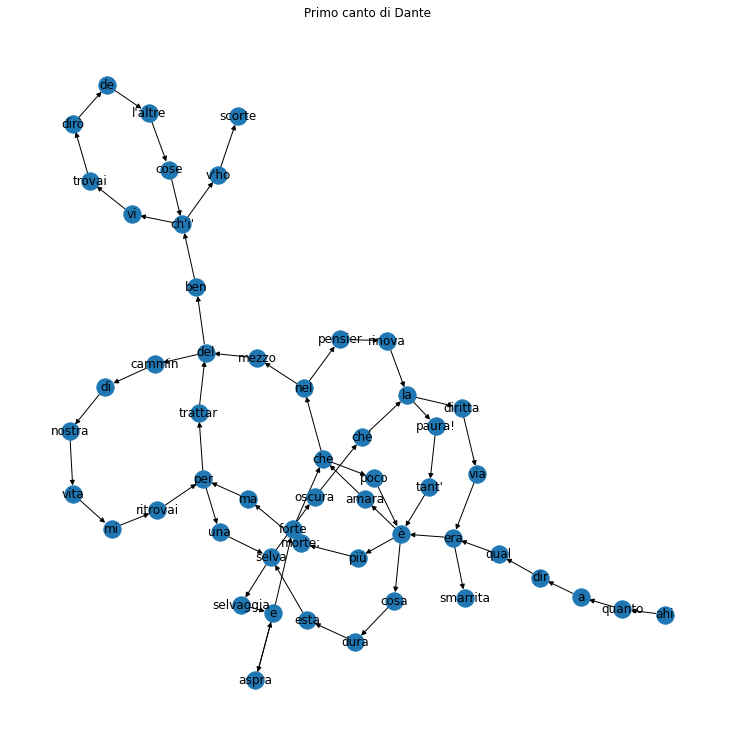

In [4]:
text = "Nel mezzo del cammin di nostra vita mi ritrovai per una selva oscura, ché la diritta via era smarrita. Ahi quanto a dir qual era è cosa dura esta selva selvaggia e aspra e forte che nel pensier rinova la paura! Tant' è amara che poco è più morte; ma per trattar del ben ch'i' vi trovai, dirò de l'altre cose ch'i' v'ho scorte."# Io non so ben ridir com' i' v'intrai, tant' era pien di sonno a quel punto che la verace via abbandonai. Ma poi ch'i' fui al piè d'un colle giunto, là dove terminava quella valle che m'avea di paura il cor compunto, guardai in alto e vidi le sue spalle vestite già de' raggi del pianeta che mena dritto altrui per ogne calle. Allor fu la paura un poco queta, che nel lago del cor m'era durata la notte ch'i' passai con tanta pieta. E come quei che con lena affannata, uscito fuor del pelago a la riva, si volge a l'acqua perigliosa e guata, così l'animo mio, ch'ancor fuggiva, si volse a retro a rimirar lo passo che non lasciò già mai persona viva. Poi ch'èi posato un poco il corpo lasso, ripresi via per la piaggia diserta, sì che 'l piè fermo sempre era 'l più basso. Ed ecco, quasi al cominciar de l'erta, una lonza leggiera e presta molto, che di pel macolato era coverta; e non mi si partia dinanzi al volto, anzi 'mpediva tanto il mio cammino, ch'i' fui per ritornar più volte vòlto. Temp' era dal principio del mattino, e 'l sol montava 'n sù con quelle stelle ch'eran con lui quando l'amor divino mosse di prima quelle cose belle; sì ch'a bene sperar m'era cagione di quella fiera a la gaetta pelle l'ora del tempo e la dolce stagione; ma non sì che paura non mi desse la vista che m'apparve d'un leone. Questi parea che contra me venisse con la test' alta e con rabbiosa fame, sì che parea che l'aere ne tremesse. Ed una lupa, che di tutte brame sembiava carca ne la sua magrezza, e molte genti fé già viver grame, questa mi porse tanto di gravezza con la paura ch'uscia di sua vista, ch'io perdei la speranza de l'altezza. E qual è quei che volontieri acquista, e giugne 'l tempo che perder lo face, che 'n tutti suoi pensier piange e s'attrista; tal mi fece la bestia sanza pace, che, venendomi 'ncontro, a poco a poco mi ripigneva là dove 'l sol tace. Mentre ch'i' rovinava in basso loco, dinanzi a li occhi mi si fu offerto chi per lungo silenzio parea fioco. Quando vidi costui nel gran diserto, «Miserere di me», gridai a lui, «qual che tu sii, od ombra od omo certo!». Rispuosemi: «Non omo, omo già fui, e li parenti miei furon lombardi, mantoani per patrïa ambedui. Nacqui sub Iulio, ancor che fosse tardi, e vissi a Roma sotto 'l buono Augusto nel tempo de li dèi falsi e bugiardi. Poeta fui, e cantai di quel giusto figliuol d'Anchise che venne di Troia, poi che 'l superbo Ilïón fu combusto. Ma tu perché ritorni a tanta noia? perché non sali il dilettoso monte ch'è principio e cagion di tutta gioia?». «Or se' tu quel Virgilio e quella fonte che spandi di parlar sì largo fiume?», rispuos' io lui con vergognosa fronte. «O de li altri poeti onore e lume, vagliami 'l lungo studio e 'l grande amore che m'ha fatto cercar lo tuo volume. Tu se' lo mio maestro e 'l mio autore, tu se' solo colui da cu' io tolsi lo bello stilo che m'ha fatto onore. Vedi la bestia per cu' io mi volsi; aiutami da lei, famoso saggio, ch'ella mi fa tremar le vene e i polsi». «A te convien tenere altro vïaggio», rispuose, poi che lagrimar mi vide, «se vuo' campar d'esto loco selvaggio; ché questa bestia, per la qual tu gride, non lascia altrui passar per la sua via, ma tanto lo 'mpedisce che l'uccide; e ha natura sì malvagia e ria, che mai non empie la bramosa voglia, e dopo 'l pasto ha più fame che pria. Molti son li animali a cui s'ammoglia, e più saranno ancora, infin che 'l veltro verrà, che la farà morir con doglia. Questi non ciberà terra né peltro, ma sapïenza, amore e virtute, e sua nazion sarà tra feltro e feltro. Di quella umile Italia fia salute per cui morì la vergine Cammilla, Eurialo e Turno e Niso di ferute. Questi la caccerà per ogne villa, fin che l'avrà rimessa ne lo 'nferno, là onde 'nvidia prima dipartilla. Ond' io per lo tuo me' penso e discerno che tu mi segui, e io sarò tua guida, e trarrotti di qui per loco etterno; ove udirai le disperate strida, vedrai li antichi spiriti dolenti, ch'a la seconda morte ciascun grida; e vederai color che son contenti nel foco, perché speran di venire quando che sia a le beate genti. A le quai poi se tu vorrai salire, anima fia a ciò più di me degna: con lei ti lascerò nel mio partire; ché quello imperador che là sù regna, perch' i' fu' ribellante a la sua legge, non vuol che 'n sua città per me si vegna. In tutte parti impera e quivi regge; quivi è la sua città e l'alto seggio: oh felice colui cu' ivi elegge!». E io a lui: «Poeta, io ti richeggio per quello Dio che tu non conoscesti, a ciò ch'io fugga questo male e peggio, che tu mi meni là dov' or dicesti, sì ch'io veggia la porta di san Pietro e color cui tu fai cotanto mesti». Allor si mosse, e io li tenni dietro."
graph = build_graph(text)
plot_graph(graph, title='Primo canto di Dante')

As we can see, the simple rule for the graph creation is that each node is connected to the previous and the next word in the text. The only exception is the first and the last word, which are connected only to the next and the previous word respectively. Each unique word is represented by a single node and this allows for complex topologies instead of a simple chain of nodes.

We now import a dataset of poetry from Kaggle and select 2 authors to study. The objective is to train the network to classify nodes based on the graph topology of the poems and distinguish between the two authors.

In [5]:
poetry_data = pd.read_csv('kaggle_poem_dataset.csv')
poetry_data['Author'].unique()

array(['Wendy Videlock', 'Hailey Leithauser', 'Jody Gladding', ...,
       'Hadewijch II', 'Judith Kroll', 'Eleni Sikelianos'], dtype=object)

In [7]:
shakespeare_poetry = poetry_data.loc[poetry_data['Author'] == 'William Shakespeare']
wordsworth_poetry = poetry_data.loc[poetry_data['Author'] == 'William Wordsworth']

We preprocess the poems:

In [11]:
authors_df = [shakespeare_poetry, wordsworth_poetry]
for author in authors_df:
    author.loc[:,'Content'] = author.loc[:,'Content'].apply(fix_newline)
    author.loc[:,'Content'] = author.loc[:,'Content'].apply(lambda x: remove_braket_text(x))
    author.loc[:,'Content'] = author.loc[:,'Content'].fillna('').astype(str)
    author.loc[:,'Content'] = author.loc[:,'Content'].apply(lambda x: x.replace('  ', ' '))

shakespeare_poetry['Content'].iloc[1]

'Her lily hand her rosy cheek lies under, Cozening the pillow of a lawful kiss; Who, therefore angry, seems to part in sunder, Swelling on either side to want his bliss; Between whose hills her head entombed is; Where like a virtuous monument she lies, To be admired of lewd unhallowed eyes. Without the bed her other fair hand was, On the green coverlet, whose perfect white Showed like an April daisy on the grass, With pearly sweat resembling dew of night. Her eyes, like marigolds, had sheathed their light, And canopied in darkness sweetly lay Till they might open to adorn the day. Her hair like golden threads played with her breath O modest wantons, wanton modesty! Showing life’s triumph in the map of death, And death’s dim look in life’s mortality. Each in her sleep themselves so beautify As if between them twain there were no strife, But that life lived in death, and death in life. Her breasts like ivory globes circled with blue, A pair of maiden worlds unconquerèd, Save of their lor

And build the graphs:

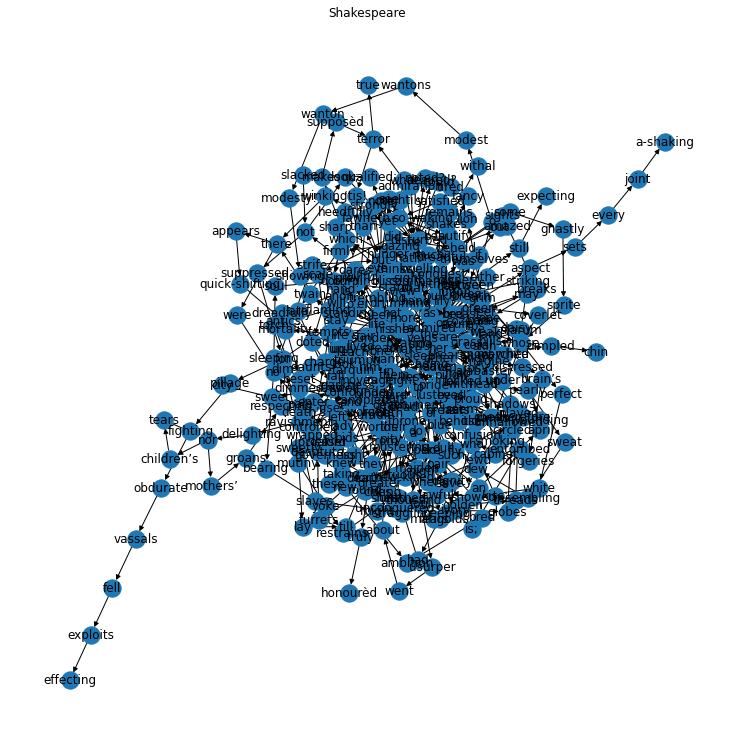

In [12]:
graph = build_graph(shakespeare_poetry['Content'].iloc[1])
plot_graph(graph, title='Shakespeare')

This time the graph looks messy because of the length of the poem. We choose a size range for the poems to be considered and we remove the ones that are too short or too long:

In [13]:
genres = [author['Content'].iloc[:] for author in authors_df]
#%%
temp_list = []
for genre in genres:
    genre = [p for p in genre if len(p) > 30 and len(p) < 1000]
    temp_list.append(genre)
    # print(len(genre))
genres = temp_list

N_CLASSES = len(genres)

We now define a Dataset class.

In [14]:
class CustomDataset(Dataset):
    def __init__(self, graph_data:GraphData = None):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        if graph_data != None:
            if type(graph_data) == list:
                self.data = graph_data
            else:
                self.data = [graph_data.detach().cpu().unsqueeze(0)]
        else:
            self.data = []
        # self.data_dir = data_dir
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # print(self.data[idx])
        if type(idx) == int:
            return self.data[idx].to(self.device)
        if type(idx) == list:
            #return pytorch tensor
            return torch.tensor(self.data[idx]).to(self.device)
            # return [self.data[i].to(self.device) for i in idx]
        # return [self.data[id].to(self.device) for id in idx]
    
    def add_data(self, graph_data:GraphData):
        # self.data = torch.cat((self.data, graph_data.detach().cpu().unsqueeze(0)))
        self.data.append(graph_data.detach().cpu())
        
    def train_test_split(self, test_size=0.2):
        test_size = int(test_size * len(self.data))
        test_data = self.data[:test_size]
        train_data = self.data[test_size:]
        return train_data, test_data
        # split data into train and test
        # test_size = int(test_size * len(self.data))
        # test_data = self.data[:test_size]
        # train_data = self.data[test_size:]
        # return train_data, test_data
    def shuffle(self):
        # shuffle data list with seed
        random.seed(SEED)
        random.shuffle(self.data)

Let's examine the data a bit more closely by counting the degree distribution of the nodes in the graphs:

100%|██████████| 31/31 [00:00<00:00, 968.94it/s]


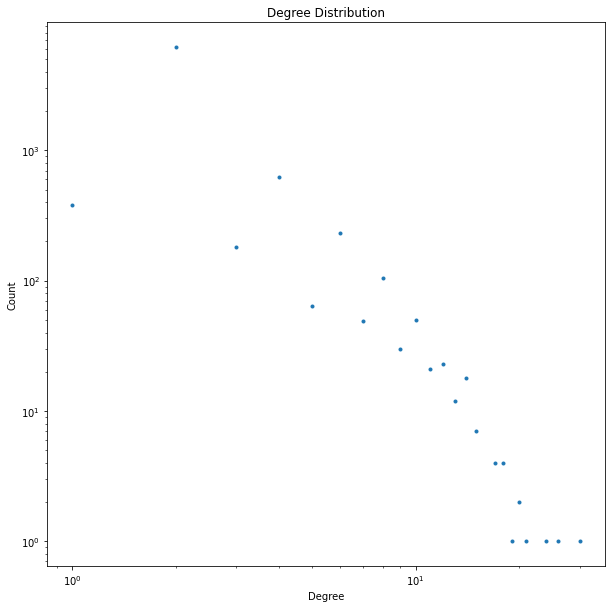

In [20]:
degree_groups_list = []
for i, genre in enumerate(genres):
    for text in tqdm(genre):
        graph = build_graph(text)
        degree = graph.degree()
        # group by degree
        degree_groups = {}
        for node, degree in dict(degree).items():
            if degree not in degree_groups:
                degree_groups[degree] = []
            degree_groups[degree].append(node)
        # break
        degree_groups_list.append(degree_groups)
        
# degree_groups_list[-1]
degree_counts = {}
for i, degree_groups in enumerate(degree_groups_list):
    
    for degree, nodes in degree_groups.items():
        if degree not in degree_counts:
            degree_counts[degree] = 0
        degree_counts[degree] += len(nodes)
# degree_counts
plt.figure(figsize=(10,10))
plt.scatter(list(degree_counts.keys()), list(degree_counts.values()), marker='.')
# log scale
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.show()

We can finally get to the point. We will use the Node2Vec algorithm to learn a vectorial representation of each node in the graph. The algorithm is based on the idea that the nodes that are close in the graph are also close in the vectorial space. The algorithm is implemented in the library node2vec.

NOTE: this takes a while to run so I suggest to skip this step and load the precomputed embeddings in the next cell.

In [ ]:
# Creates dataset from texts adding node features with Node2Vec
EMBEDD_LEN = 8

dataset = CustomDataset()
for i, genre in enumerate(genres):
    for text in genre:
        # i = 0 #VERY TEMPORARY
        graph = build_graph(text)
        
        WINDOW = 1 # Node2Vec fit window
        MIN_COUNT = 1 # Node2Vec min. count
        BATCH_WORDS = 4 # Node2Vec batch words
        
        # Node2Vec
        ###############################################################################
        g_emb = n2v(
        graph,
        dimensions=EMBEDD_LEN
        )
        
        mdl = g_emb.fit(
            vector_size = EMBEDD_LEN,
            window=WINDOW,
            min_count=MIN_COUNT,
            batch_words=BATCH_WORDS
        )
        
        for node in graph.nodes():
            # Add feature to node
            graph.nodes[node]['x'] = mdl.wv.get_vector(str(node))
        ###############################################################################
        
        graph_data = from_networkx(graph).cpu()
        
        labels = torch.zeros(graph_data.num_nodes, dtype=torch.long) + i #VERY TEMPORARY
        # i = i+1 #VERY TEMPORARY
        
        # transforms labels to one-hot
        labels = torch.eye(N_CLASSES)[labels]
        
        graph_data.y = labels
        dataset.add_data(graph_data)
torch.save(dataset, 'poetry_dataset_embed_8.pt')
dataset[1].x

We load the embeddings and declare dataloaders for training and testing:

In [24]:
dataset = torch.load('pruned_shakespeare_vs_wordsworth_dataset_embed_8.pt')
EMBEDD_LEN = 8
SEED = 42
dataset.shuffle()
train_data, test_data = dataset.train_test_split(test_size=0.25)
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=450, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=150, shuffle=True)

Here's the model definition: it uses a Graph Convolutional Network to combine the vectorial representation of each node with the topology of the graph to classify each node in the graph. The network will be trained on a set of labeled texts and will be able to classify new words/texts.

In [25]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(EMBEDD_LEN, EMBEDD_LEN)
        self.conv2 = GCNConv(EMBEDD_LEN, EMBEDD_LEN)
        self.conv3 = GCNConv(EMBEDD_LEN, EMBEDD_LEN)
        self.conv4 = GCNConv(EMBEDD_LEN, EMBEDD_LEN)
        
        # self.classifier1 = GCNConv(EMBEDD_LEN, N_CLASSES)
        #fully connected sequential classifier
        self.classifier1 = torch.nn.Sequential(
            torch.nn.Linear(EMBEDD_LEN, EMBEDD_LEN),
            torch.nn.ReLU(),
            torch.nn.Linear(EMBEDD_LEN, EMBEDD_LEN),
            torch.nn.ReLU(),
            torch.nn.Linear(EMBEDD_LEN, EMBEDD_LEN),
            torch.nn.ReLU(),
            torch.nn.Linear(EMBEDD_LEN, N_CLASSES)
            
        )
    def forward(self, data:GraphData):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        
        # class_v = self.classifier1(x, edge_index)
        class_v = self.classifier1(x)
        return [x, F.log_softmax(class_v, dim=1)]

Here we can choose whether to load the precomputed weights:

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


LOAD = False


model = GCN().to(device)
if LOAD:
    model.load_state_dict(torch.load('model_state_dict_poetry_embed_8.pt'))


And finally we train the model:

100%|██████████| 650/650 [00:47<00:00, 13.67it/s]


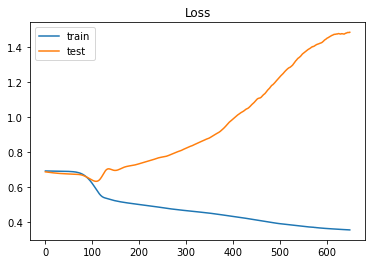

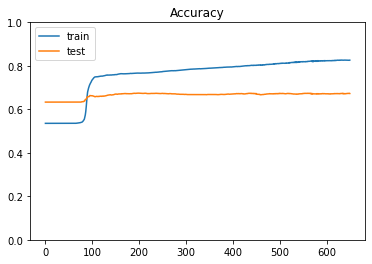

In [28]:
EPOCHS = 650
loss_f = nn.CrossEntropyLoss()
losses = []
accuracies = []
test_accuracies = []
test_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
for epoch in tqdm(range(int(EPOCHS))):
    for data in train_loader:
        optimizer.zero_grad()
        x, class_v = model(data)
        class_s = torch.argmax(class_v, dim=1)
        label_s = torch.argmax(data.y, dim=1)
        loss = loss_f(class_v.view(-1,N_CLASSES), data.y.view(-1,N_CLASSES))
        loss.backward()
        # losses.append(loss.item())
        optimizer.step()
            
            # This changes the graph, should not be active unless you're sure
            # data.x = copy.deepcopy(x.detach()) #Updates data.x, learning a useful representation
            
        losses.append(loss.item())
        # norms.append(torch.norm(data.x).item())
        accuracies.append(torch.eq(class_s, label_s).float().detach().cpu().mean())
        # embeddings.append([x.detach().cpu(),label_s.detach().cpu()])
    # eval
    for data in test_loader:
        x, class_v = model(data)
        class_s = torch.argmax(class_v, dim=1)
        label_s = torch.argmax(data.y, dim=1)
        test_accuracies.append(torch.eq(class_s, label_s).float().detach().cpu().mean())
        test_losses.append(loss_f(class_v.view(-1,N_CLASSES), data.y.view(-1,N_CLASSES)).item())
        # embeddings.append([x.detach().cpu(),label_s.detach().cpu()])

#save model state dict
# torch.save(model.state_dict(), 'model_state_dict_poetry_embed_8.pt')
#%%
plt.plot(losses)
plt.plot(test_losses)
plt.title('Loss')
plt.legend(['train','test'])
plt.show()

#plot horizontal line at y = 0.5
plt.plot(accuracies)
plt.plot(test_accuracies)
plt.ylim(0,1)
plt.title('Accuracy')
plt.legend(['train','test'])
plt.show()


The task of assigning nodes to an author based only on the graph topology is not trivial. The network is able to achieve an accuracy of about 0.65 on the test set, which is not bad considering that the network has no notion of semantic similarity between words. 
Remembering that the accuracy is calculated on single words, this is more than enough to classify a whole text by majority vote.

Let's now focus on showing how the model organizes nodes in the vectorial space. We will use a few algorithms to project the nodes in plottable space. We will use the same color for nodes belonging to the same author.

In [31]:
embeddings = torch.Tensor()
for data in test_dataset:
    x, class_v = model(data)
    vector = torch.cat([x, torch.argmax(data.y, dim=1).view(-1,1)], dim=1).detach().cpu()
    embeddings = torch.cat([embeddings, vector], dim=0)

We start with a simple Principal Component Analysis. 
One can choose the number of components to use for the projection but to be able to plot, of course, we can only use 2 or 3 components.

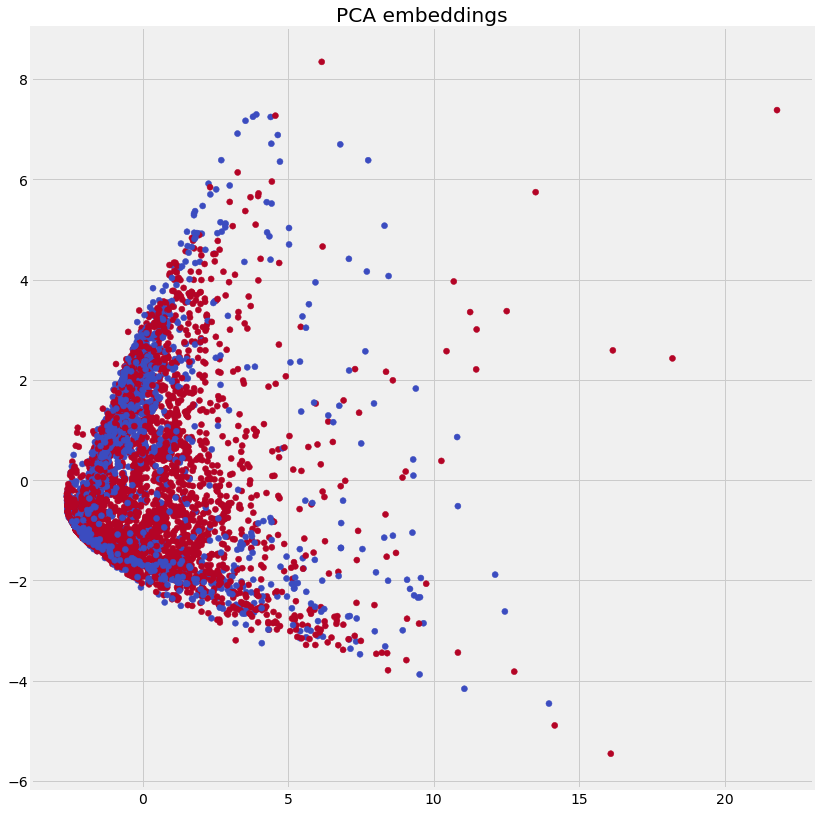

In [32]:
n_components = 2 # or 3
pca_reduced_embeddings = PCA(n_components=n_components).fit_transform(np.array(embeddings)[:,:-1])
embed_labels = np.array(embeddings)[:,-1]
#%%
fig = plt.figure()
plt.style.use('fivethirtyeight')
fig.set_size_inches(14, 14)
if n_components == 2:
    # 2D variant
    plt.scatter(pca_reduced_embeddings[:,0], pca_reduced_embeddings[:,1], c=embed_labels, cmap='coolwarm')
if n_components == 3:
    # 3D variant
    ax = fig.add_subplot(projection='3d')
    ax.scatter(pca_reduced_embeddings[:,0], pca_reduced_embeddings[:,1], pca_reduced_embeddings[:,2], c=embed_labels, cmap='coolwarm') # change color of labels to red and blue
plt.savefig("PCA test.svg", format="svg")
plt.savefig("PCA test.png", format="png")
plt.title('PCA embeddings')
plt.show()

Next we use t-SNE to project the nodes in 2D space. t-SNE is a non-linear dimensionality reduction algorithm that is particularly well suited for the visualization of high-dimensional datasets.

Note: this is much slower than PCA.

c:\Users\gufer\Anaconda3\envs\netml\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\gufer\Anaconda3\envs\netml\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


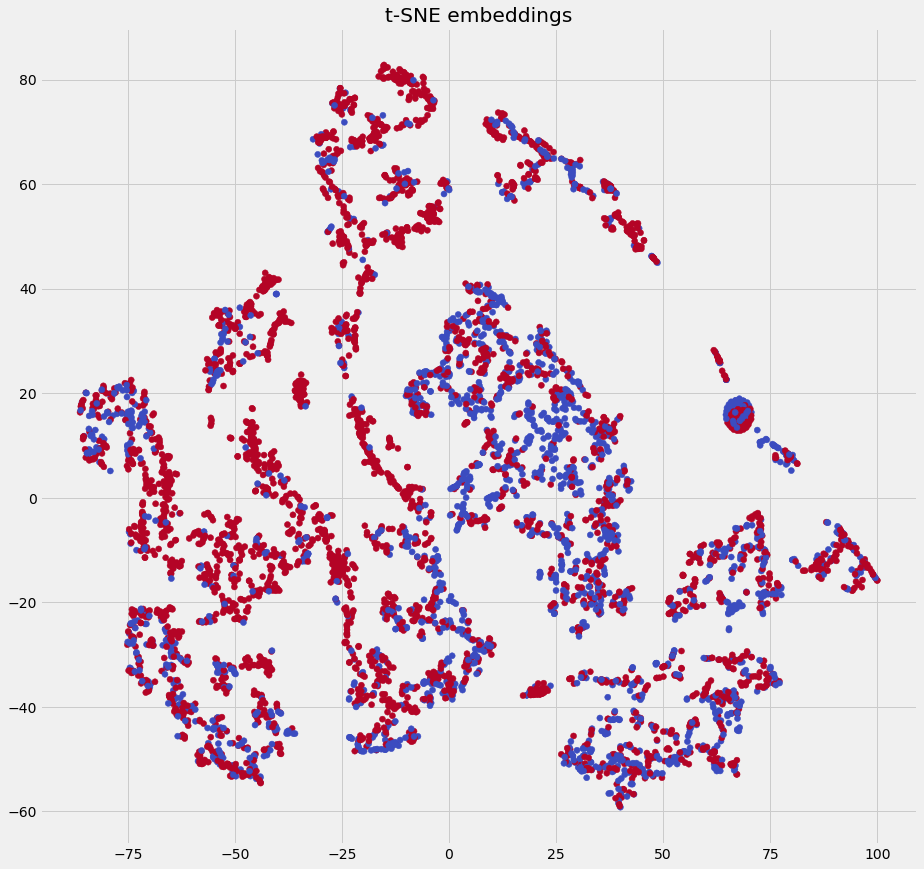

In [33]:
reduced_embeddings = TSNE(n_components=n_components).fit_transform(np.array(embeddings)[:,:-1])
#%%
fig = plt.figure()
plt.style.use('fivethirtyeight')
fig.set_size_inches(14, 14)
if n_components == 2:
    # 2D variant
    plt.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], c=embed_labels, cmap='coolwarm')
if n_components == 3:
    # 3D variant
    ax = fig.add_subplot(projection='3d')
    ax.scatter(reduced_embeddings[:,0], reduced_embeddings[:,1], reduced_embeddings[:,2], c=embed_labels, cmap='coolwarm') # change color of labels to red and blue
plt.savefig("TSNE test.svg", format="svg")
plt.savefig("TSNE test.png", format="png")
plt.title('t-SNE embeddings')
plt.show()

Here we start to clearly see a 'gradient' in colors, which means that the model is able to distinguish between the two authors.

Finally we use UMAP to project the nodes in 2D space. UMAP is a dimensionality reduction technique that can be used for visualization similarly to t-SNE.

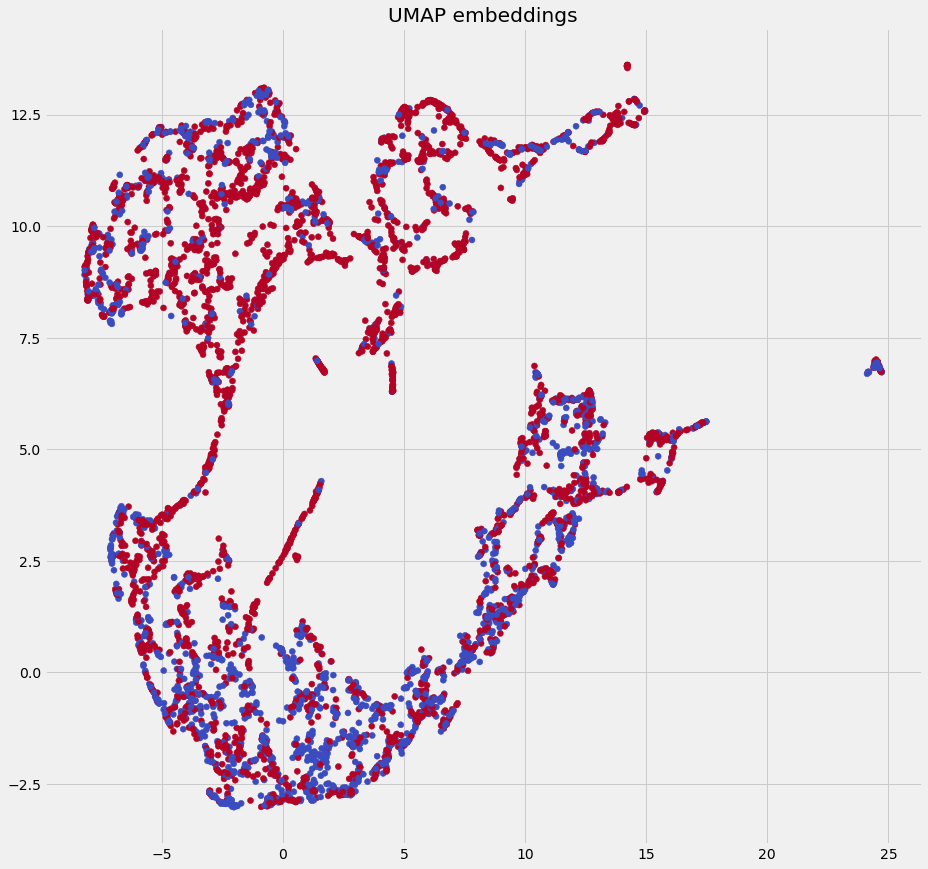

In [34]:
umap_reduced_embeddings = umap.UMAP().fit_transform(np.array(embeddings)[:,:-1])
#%%
fig = plt.figure()
fig.set_size_inches(14, 14)
plt.title('UMAP embeddings')
plt.scatter(umap_reduced_embeddings[:,0], umap_reduced_embeddings[:,1], c=np.array(embeddings)[:,-1], cmap='coolwarm')
plt.savefig("UMAP test.svg", format="svg")
plt.savefig("UMAP test.png", format="png")
plt.show()